# CS1090A Final Project
#### Group 71: Gulirano Almuratova, Eva Pierre Antoine, Victoria Levy, Linh Vu, Binh Vu 
#### Project 43: Predicting US Health Insurance Premiums 

## Introduction 
### Finalized Research Question
Healthcare plans in the United States are polemic and influential topics, affecting millions of Americans every day. Such plans primarily involve insurances and programs that are responsible for covering costs that people might accrue related to any types of medical expenses; they vary expansively based on what they offer, how they relate to people’s careers, and people’s individual characteristics. Our project aims to classify individuals based on the cost of their healthcare premiums (the monthly cost paid for a healthcare plan). Using personal and demographic characteristics, we categorize premiums into three groups: low (individuals who pay nothing, i.e., HIPCOST = 0), medium (those who pay less than $7,000 annually, a threshold derived from the Affordable Care Act’s definition of affordability as 9% of the median U.S. income), and high (those who pay more than $7,000 annually). By framing the problem as a classification task, we aim to provide insights into the factors influencing healthcare affordability and premium costs.


### Data Description
Our project utilizes data from the 2022 National Health Interview Survey (NHIS), a comprehensive dataset collected annually by the National Center for Health Statistics to capture various aspects of Americans’ health, healthcare access, and insurance coverage. The NHIS uses a stratified multistage probability sampling approach, ensuring representation across diverse demographic and socioeconomic groups. The dataset includes detailed information on individuals’ healthcare plans, personal demographics, health status, and social factors. For our project, we chose only relevant variables including healthcare premium costs, demographic characteristics (e.g., age, gender, race, and education level), health ratings, and lifestyle factors such as marital and employment status. We filtered the data to only include 18+ individuals and those with private health insurance. 

### Data Preparation
With a new dataset from our previous milestone, we began by cleaning and reformatting categorical variables, translating numerical codes into meaningful descriptors (e.g., yearly doctor visits, gender, health rating, education, race, region, and marital status). Binary variables, such as military service, citizenship, and employment status, were standardized to 0 and 1 values. To address missing data, we excluded rows lacking definitive healthcare premium information (e.g., missing, unknown, or refused responses). We decided against imputing values for this as it is our predictor variable; it seemed counterintuitive to predict a value to impute and then use our model to then predict that value again. Additionally, we had to recode certain variables due to the differences in universes. For example, those who did not smoke were not asked how often they smoked. In such cases, we recoded the NaNs to a 0. 


In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

In [2]:
# For calculating total notebook runtime
notebook_start = time.time()

In [3]:
# load data
cleaned_df = pd.read_csv("cleaned_data.csv")

In [4]:
# drop var with lots of NAs
cols_to_keep = ['AGE', 'BMICALC', 
                       'MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY',
                       'GOTWELF', 'DEMENTIAEV', 'CITIZEN','HIPCOST']
df = cleaned_df[cols_to_keep].dropna()

In [5]:
# recode into Low, Medium, High categories
t1 = 1
t2 = 7000
df['HIPCOST'] = pd.cut(df['HIPCOST'],
                       bins=[0,t1,t2,50000],
                       labels=['Low','Medium','High'],
                       include_lowest=True).astype(str)

# check for balance
df['HIPCOST'].value_counts()

HIPCOST
Medium    7640
Low       2928
High      1479
Name: count, dtype: int64

### EDA of Variables Chosen for Model 
After we did our initital EDA, we reduced the number of variables we would be using in our final classification model. These variables include age, BMI, marital status, region, last doctors visit, frequency of smoking, race, education, poverty level, if they receive welfare, if they have dementia, as well as citizenship status. This refined list represents a combination of factors that, based on our analysis, are likely to provide the most predictive power while ensuring interpretability. From here, we wanted to look at the spread of each of these variables to investigate the relationships. 

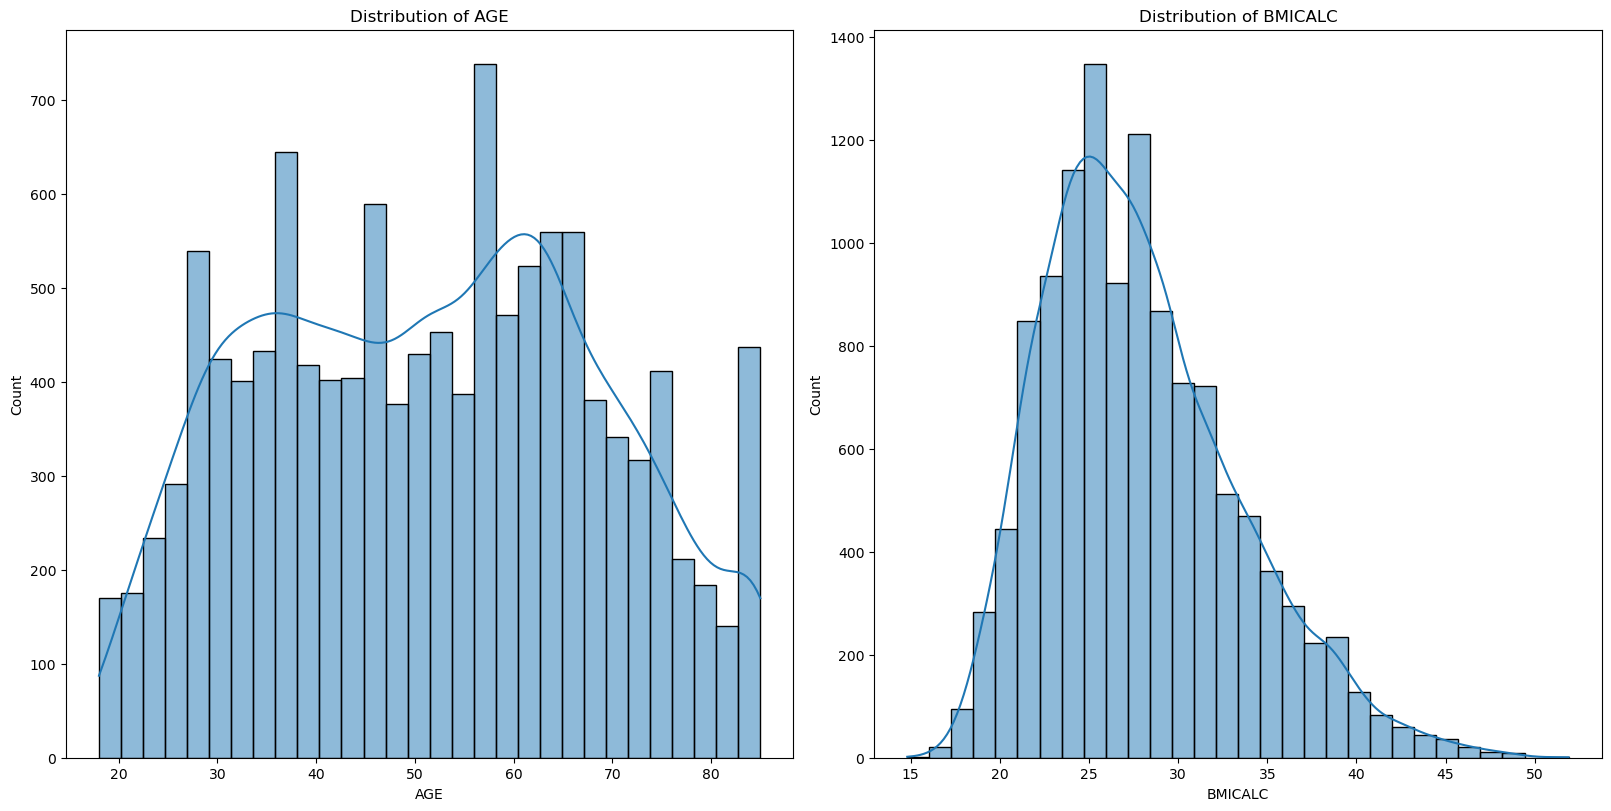

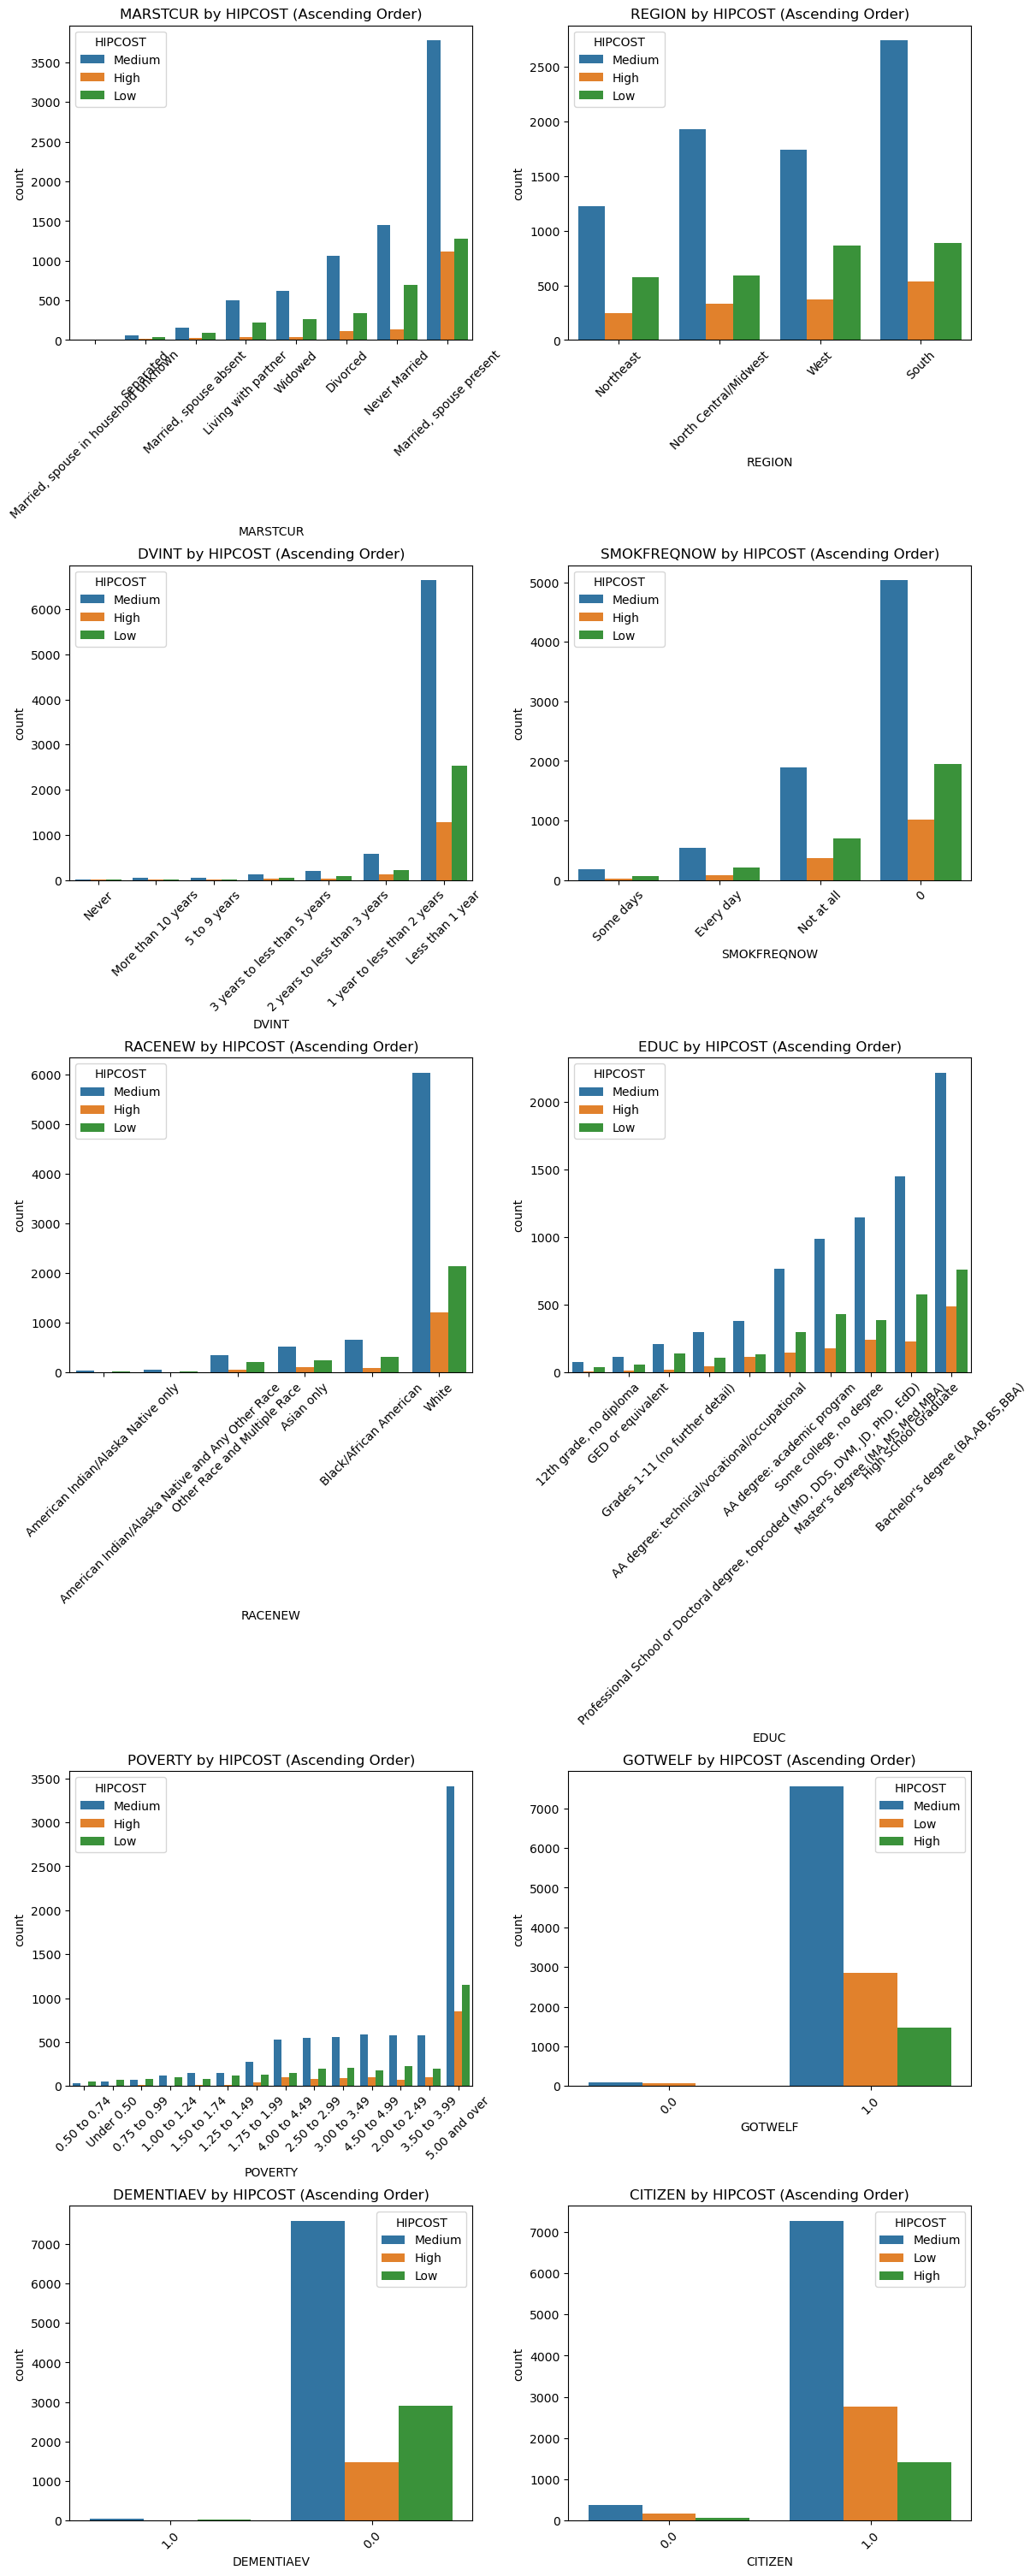

In [34]:
import math
eda_vars = ['AGE', 'BMICALC', 'MARSTCUR', 'REGION', 'DVINT', 
            'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY', 
            'GOTWELF', 'DEMENTIAEV', 'CITIZEN', 'HIPCOST']

eda_df = df[eda_vars]

numerical_vars = ['AGE', 'BMICALC']
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

for i, var in enumerate(numerical_vars):
    sns.histplot(eda_df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {var}")

plt.show()

categorical_vars = ['MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 
                    'RACENEW', 'EDUC', 'POVERTY', 'GOTWELF', 'DEMENTIAEV', 'CITIZEN']

fig, axes = plt.subplots(5, 2, figsize=(2* 6, 5 * 6), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sorted_categories = eda_df[var].value_counts(ascending=True).index
    sns.countplot(ax=axes[i], x=var, hue='HIPCOST', data=eda_df, order=sorted_categories)
    axes[i].set_title(f"{var} by HIPCOST (Ascending Order)")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.show()


### Building the Baseline Model
#### Decision Tree Classifier
We begin by using One Hot Encoding on the categorical variables so that they can be put into the models correctly. From there, we split the data into the training set and the test set so that we can test our model on some unused data at the end to see the accuracy. Then, we performed a grid search using cross-validation to find the optimal hyperparameters for a DecisionTreeClassifier. Based on the accuracy score from the cross validation, the Decision Tree did not work out very well. Therefore, we moved onto try a Random Forest Classiciation model. 

In [6]:
X = pd.get_dummies(df[['AGE', 'BMICALC', 
                       'MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY',
                       'GOTWELF', 'DEMENTIAEV', 'CITIZEN']], 
                   columns=['MARSTCUR', 'REGION','DVINT','SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY'], 
                   dtype = int,
                   drop_first = True)

y = df['HIPCOST']
display(X.describe())
print(X.info())

,AGE,BMICALC,GOTWELF,DEMENTIAEV,CITIZEN,MARSTCUR_Living with partner,"MARSTCUR_Married, spouse absent","MARSTCUR_Married, spouse in household unknown","MARSTCUR_Married, spouse present",MARSTCUR_Never Married,...,POVERTY_1.50 to 1.74,POVERTY_1.75 to 1.99,POVERTY_2.00 to 2.49,POVERTY_2.50 to 2.99,POVERTY_3.00 to 3.49,POVERTY_3.50 to 3.99,POVERTY_4.00 to 4.49,POVERTY_4.50 to 4.99,POVERTY_5.00 and over,POVERTY_Under 0.50
count,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,...,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000,12047.000000
mean,51.526521,27.897377,0.985640,0.007139,0.950942,0.063252,0.023325,0.000083,0.511912,0.189093,...,0.020503,0.037105,0.072466,0.068897,0.070723,0.072549,0.064995,0.071387,0.448410,0.010459
std,17.175359,5.489224,0.118976,0.084192,0.215998,0.243426,0.150941,0.009111,0.499879,0.391599,...,0.141719,0.189026,0.259269,0.253289,0.256372,0.259406,0.246528,0.257481,0.497352,0.101737
min,18.000000,14.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,23.800000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,27.100000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,31.200000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,85.000000,51.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 12047 entries, 0 to 12625
Data columns (total 51 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   AGE                                                                                 12047 non-null  float64
 1   BMICALC                                                                             12047 non-null  float64
 2   GOTWELF                                                                             12047 non-null  float64
 3   DEMENTIAEV                                                                          12047 non-null  float64
 4   CITIZEN                                                                             12047 non-null  float64
 5   MARSTCUR_Living with partner                                                        12047 non-null  

In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9637, 51), (2410, 51), (9637,), (2410,))

In [8]:
param_grid = {'criterion': ['entropy'],
              'max_depth': [3, 5, 10],
              'max_leaf_nodes': [10, 15, 20],
              'class_weight': ['balanced']}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    
    n_jobs=-1  
)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [3, 5, 10],
                         'max_leaf_nodes': [10, 15, 20]},
             scoring='accuracy')

In [9]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_leaf_nodes': 10}

In [10]:
grid_search.cv_results_
cross_val_score(estimator=grid_search.best_estimator_,X=X_train,y=y_train,cv=10)

array([0.45539419, 0.43568465, 0.45228216, 0.4626556 , 0.45954357,
       0.50414938, 0.47717842, 0.47248183, 0.48494289, 0.46521288])

In [11]:
cross_val_score(estimator=grid_search.best_estimator_,X=X_train,y=y_train,cv=10)

array([0.45539419, 0.43568465, 0.45228216, 0.4626556 , 0.45954357,
       0.50414938, 0.47717842, 0.47248183, 0.48494289, 0.46521288])

In [12]:
best_tree = grid_search.best_estimator_
y_pred_tree = best_tree.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.47676348547717845

#### Trying Random Forest
Similar to the Decision Tree Model, we conducted a grid search with cross-validation to optimize hyperparameters for the Random Forest Classifier. After identifying the optimal parameters, we trained the model on the training dataset and evaluated its performance on the reserved testing dataset. While the Decision Tree Classifier achieved an accuracy of approximately 47%, the Random Forest Classifier improved this to 60%, demonstrating a significant enhancement in predictive performance.

In [13]:
y_train.head()

5145     Medium
2471     Medium
8510     Medium
11037    Medium
8575       High
Name: HIPCOST, dtype: object

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [10],
    'class_weight': ['balanced']
}

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Set up GridSearchCV
grid_search2 = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1)
grid_search2.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search2.best_params_
best_rf = grid_search2.best_estimator_

print(f"Best Parameters: {best_params}")

Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 200}


In [15]:
cross_val_score(estimator = grid_search2.best_estimator_, X = X_train,y = y_train, cv = 10)

array([0.59543568, 0.61307054, 0.60580913, 0.59854772, 0.59958506,
       0.62448133, 0.59751037, 0.60539979, 0.60747664, 0.60332295])

In [16]:
# Evaluate the best model
y_pred_rf = best_rf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.6074688796680497

### Interpreting the Results from Random Forest Model

In [17]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 3.72 minutes for this notebook to run
